# Image captioning

In [1]:
!pip install transformers datasets evaluate -q
!pip install jiwer -q
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 57.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 50.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 101.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 3.9 MB/s eta 0:00:00


# logging Hugginface hub

In [2]:
from huggingface_hub import notebook_login

notebook_login()

# load dataset

In [3]:
from datasets import load_dataset

ds = load_dataset("hieudinhpro/diffuision-dataset2")
ds

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/9999 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 9999
    })
})

In [4]:
ds = ds["train"].train_test_split(test_size=0.1)
train_ds = ds["train"]
test_ds = ds["test"]

### Let’s visualize a couple of samples from the training set.

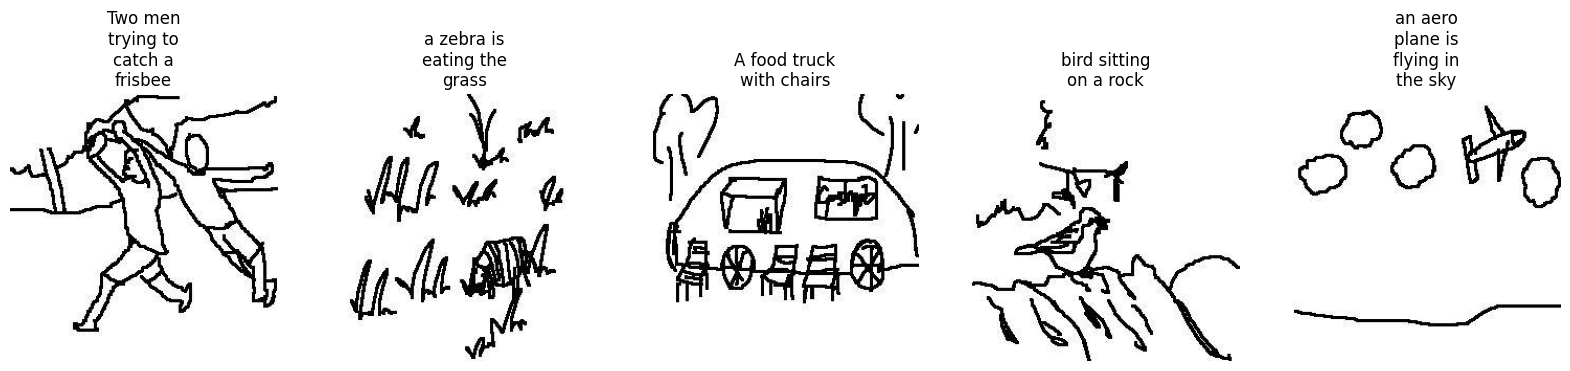

In [5]:
from textwrap import wrap
import matplotlib.pyplot as plt
import numpy as np


def plot_images(images, captions):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        caption = captions[i]
        caption = "\n".join(wrap(caption, 12))
        plt.title(caption)
        plt.imshow(images[i])
        plt.axis("off")


sample_images_to_visualize = [np.array(train_ds[i]["image"]) for i in range(5)]
sample_captions = [train_ds[i]["text"] for i in range(5)]
plot_images(sample_images_to_visualize, sample_captions)

# Preprocess the dataset

Since the dataset has two modalities (image and text), the pre-processing pipeline will preprocess images and the captions.

In [6]:
from transformers import AutoProcessor

checkpoint = "microsoft/git-base"
processor = AutoProcessor.from_pretrained(checkpoint)

The processor will internally pre-process the image (which includes resizing, and pixel scaling) and tokenize the caption.

In [7]:
def transforms(example_batch):
    images = [x for x in example_batch["image"]]
    captions = [x for x in example_batch["text"]]
    inputs = processor(images=images, text=captions, padding="max_length")
    inputs.update({"labels": inputs["input_ids"]})
    return inputs


train_ds.set_transform(transforms)
test_ds.set_transform(transforms)

# Load a base model

In [8]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(checkpoint)

Image captioning models are typically evaluated with the Rouge Score or Word Error Rate. For this guide, you will use the Word Error Rate (WER).

In [9]:
# from evaluate import load
import torch

# wer = load("wer")


# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     predicted = logits.argmax(-1)
#     decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
#     decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)
#     wer_score = wer.compute(predictions=decoded_predictions, references=decoded_labels)
#     return {"wer_score": wer_score}

# Train!

## I dont have a lot of GPU ram ==>> training 2 examples each time

In [10]:
from transformers import TrainingArguments,Trainer



model_name = checkpoint.split("/")[1]

training_args = TrainingArguments(
    output_dir=f"{model_name}-on-diffuision-dataset2",
    learning_rate=2e-5,
    num_train_epochs=1,
    per_device_train_batch_size=4,
    # per_device_eval_batch_size=1,
    gradient_accumulation_steps=2,
    save_total_limit=1,
    # evaluation_strategy="steps",
    # eval_steps=1,
    save_strategy="steps",
    save_steps=10,
    logging_steps=10,
    remove_unused_columns=False,
    push_to_hub=True,
    label_names=["labels"],
    load_best_model_at_end=False,
)


In [11]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds
)
trainer.train()

Step,Training Loss
10,10.023500
20,8.791300
30,8.246900
40,7.806500
50,7.397300
60,6.980400
70,6.549400
80,6.130900
90,5.709700
100,5.285100


Step,Training Loss
10,10.023500
20,8.791300
30,8.246900
40,7.806500
50,7.397300
60,6.980400
70,6.549400
80,6.130900
90,5.709700
100,5.285100


TrainOutput(global_step=1125, training_loss=0.9938312581512663, metrics={'train_runtime': 2839.0515, 'train_samples_per_second': 3.17, 'train_steps_per_second': 0.396, 'total_flos': 4208676057778176.0, 'train_loss': 0.9938312581512663, 'epoch': 1.0})

In [12]:
trainer.push_to_hub()


pytorch_model.bin:   0%|          | 0.00/707M [00:00<?, ?B/s]

'https://huggingface.co/hieudinhpro/git-base-on-diffuision-dataset2/tree/main/'

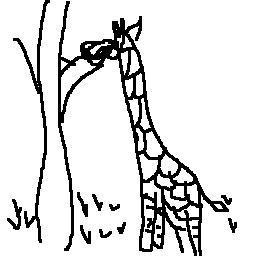

In [14]:
from PIL import Image

image = Image.open('/content/image.jpg')
image

In [17]:
inputs = processor(images=image, return_tensors="pt").to('cuda')
pixel_values = inputs.pixel_values

In [18]:
generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

a giraffe is eating grass


In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
model.push_to_hub('hieudinhpro/diffuision-dataset3')

pytorch_model.bin:   0%|          | 0.00/707M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/hieudinhpro/diffuision-dataset3/commit/de29fdaf542984d45c6853bb23bbe64bfadeb929', commit_message='Upload GitForCausalLM', commit_description='', oid='de29fdaf542984d45c6853bb23bbe64bfadeb929', pr_url=None, pr_revision=None, pr_num=None)

In [23]:
checkpoint1 = "microsoft/git-base"
test_proceser  = AutoProcessor.from_pretrained(checkpoint1)

checkpoint2 ="/content/drive/MyDrive/git-base-on-diffuision-dataset2"
model2 = AutoModelForCausalLM.from_pretrained(checkpoint2)

In [24]:
inputs = test_proceser(images=image, return_tensors="pt")
pixel_values = inputs.pixel_values

In [25]:
generated_ids = model2.generate(pixel_values=pixel_values, max_length=50)
generated_caption = test_proceser.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

a giraffe is eating leaves from a tree


In [26]:
processor.push_to_hub('hieudinhpro/diffuision-dataset3')

CommitInfo(commit_url='https://huggingface.co/hieudinhpro/diffuision-dataset3/commit/148235aecc0978bdc2d97d279921df009db0d9d3', commit_message='Upload processor', commit_description='', oid='148235aecc0978bdc2d97d279921df009db0d9d3', pr_url=None, pr_revision=None, pr_num=None)